In [6]:
import pandas as pd
import numpy as np
import os
import requests
from pprint import pprint
from api_key import api_key
import csv

df = pd.DataFrame()

In [9]:
# api_key 를 다른 파일로 분류함.
url = f"http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/1/5"

def get_personal_energy_usage_data():
    responses = []
    f = open('isNull?.csv', 'w', encoding='UTF-8')
    w = csv.writer(f)
    for year in range(2015, 2024 + 1):
        for month in range(1, 12 + 1):
            response = requests.get(f'{url}/{year}/{month:02d}')
            if response.status_code == 200:
                print(f'{year}년 {month}월 api 호출 성공')
                # 개인 키워드만 포함된 데이터만 추출할 수 있도록, filter 함수 이용하여 데이터 규모 축소.
                api_result = list(filter(lambda n: n['MM_TYPE'] == '개인', response.json()['energyUseDataSummaryInfo']['row']))
                
            
                # 개인 데이터가 null 인 경우, 터미널에 추가 출력하고, csv 파일을 생성하여 저장.
                if api_result == []:
                    w.writerow([f'{year}년 {month}월 결측치 발생!'])
                    print(f'{year}년 {month}월 결측치 발생!')
                    responses.append({'YEAR': f'{year}', 'MON': f'{month:02d}', 'MM_TYPE': '개인'})
                else:
                    responses.append(api_result[0])
            else: 
                print(f'API 호출 실패: {response.status_code}')
                f.close()
    f.close()
    return responses

In [8]:
def shrink_data(df):
    renamed_cols = df.rename(columns = {'EUS': '전기', 'GUS': '가스', 'WUS': '수도', 'HUS': '지역난방'})
    selected_cols = renamed_cols[['전기', '가스', '수도', '지역난방', 'YEAR', 'MON']]
    return selected_cols
    

In [42]:
def add_season(df):
    # df['season'] =  df['MON'].map(1:'겨울', 2:'겨울', 3:'봄', 4:'봄', 5:'봄', 6:'여름', 7:'여름', 8:'여름', 9:'가을', 10:'가을', 11,
    seasons = np.array(['겨울', '봄', '여름', '가을'])
    df['season'] = seasons[((df['MON'] % 12) // 3)]
    return df

In [34]:
def interpolate_csv(df_cleaned):
    for col in df_cleaned[['전기', '가스', '수도', '지역난방']]:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].interpolate(method = 'spline', order = 3))
    print(df_cleaned.head())
    return df_cleaned

In [43]:
if os.path.isfile('cleaned_energy.csv'):
    df = pd.read_csv('./cleaned_energy.csv', header=0)
    seasonal_energies = add_season(df)
    print(df)
    df.to_csv("energy_seasonal.csv", encoding='UTF-8')
    

     Unnamed: 0            전기            가스            수도          지역난방  YEAR  \
0             0  1.937847e+08  5.913372e+07  1.281976e+07  2.274084e+07  2015   
1             1  1.899742e+08  5.648736e+07  1.265689e+07  1.879332e+07  2015   
2             2  1.785578e+08  4.725929e+07  1.214000e+07  1.239840e+07  2015   
3             3  1.706311e+08  3.470023e+07  1.202974e+07  5.819708e+06  2015   
4             4  1.772898e+08  2.206089e+07  1.308673e+07  1.320896e+06  2015   
..          ...           ...           ...           ...           ...   ...   
115         115  4.639713e+08  7.072251e+06  1.587354e+07  1.300823e+05  2024   
116         116  4.098729e+08  5.729131e+06  1.514332e+07  3.420507e+06  2024   
117         117  2.822681e+08  8.233421e+06  1.529767e+07  2.695491e+06  2024   
118         118  2.579280e+08  1.741822e+07  1.467867e+07  8.836296e+06  2024   
119         119  1.348281e+08  4.210342e+07  7.326854e+06  1.513199e+06  2024   

     MON season  
0      1 

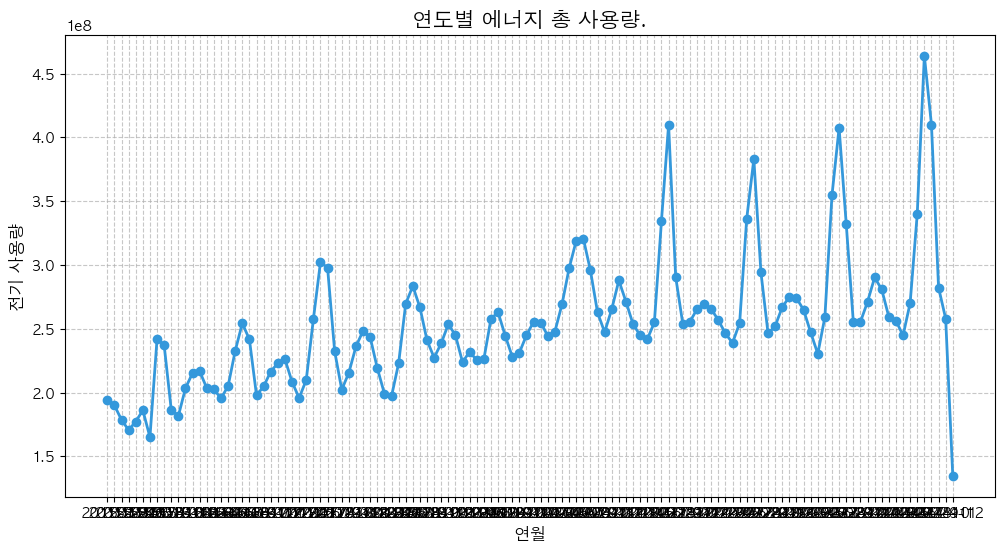

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family = 'AppleGothic')

if os.path.isfile('cleaned_energy.csv'):
    df = pd.read_csv('./cleaned_energy.csv', header=0)
    monthly_energies = df.groupby(['YEAR', 'MON'])['전기'].sum().reset_index()
    monthly_energies['YearMonth'] = monthly_energies['YEAR'].astype(str) + '-' + monthly_energies['MON'].astype(str)

    plt.figure(figsize = (12, 6))
    plt.plot(monthly_energies['YearMonth'], monthly_energies['전기'], marker = 'o', linestyle = '-', color = '#3498db', linewidth = 2)

    plt.title('연도별 에너지 총 사용량.', fontsize = 15)
    plt.xlabel('연월', fontsize = 12)
    plt.ylabel('전기 사용량', fontsize = 12)
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.show()

In [18]:
if os.path.isfile('energy.csv'):
    df = pd.read_csv('./energy.csv', header=0)
    print(df.isnull().sum())
    df_cleaned = interpolate_csv(df)
    print(df_cleaned)
    df_cleaned.to_csv('cleaned_energy.csv', index = False, encoding='UTF-8')
else:
    responses = get_personal_energy_usage_data()
    df = pd.DataFrame(responses)
    df = shrink_data(df)
    print(df)
    df.to_csv("energy.csv", encoding="UTF-8")

Unnamed: 0     0
전기            37
가스            37
수도            37
지역난방          37
YEAR           0
MON            0
dtype: int64
   Unnamed: 0            전기            가스            수도          지역난방  YEAR  \
0           0  1.937847e+08  5.913372e+07  1.281976e+07  2.274084e+07  2015   
1           1  1.899742e+08  5.648736e+07  1.265689e+07  1.879332e+07  2015   
2           2  1.785578e+08  4.725929e+07  1.214000e+07  1.239840e+07  2015   
3           3  1.706311e+08  3.470023e+07  1.202974e+07  5.819708e+06  2015   
4           4  1.772898e+08  2.206089e+07  1.308673e+07  1.320896e+06  2015   

   MON  
0    1  
1    2  
2    3  
3    4  
4    5  
     Unnamed: 0            전기            가스            수도          지역난방  YEAR  \
0             0  1.937847e+08  5.913372e+07  1.281976e+07  2.274084e+07  2015   
1             1  1.899742e+08  5.648736e+07  1.265689e+07  1.879332e+07  2015   
2             2  1.785578e+08  4.725929e+07  1.214000e+07  1.239840e+07  2015   
3             3